In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'sentiment_imdb')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Reviews

In [6]:
vocab_size = 20000

In [7]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, 
                                                      skip_top=0,
                                                      maxlen=None, 
                                                      oov_char=2, 
                                                      index_from=3,
                                                      num_words=vocab_size)

17465344/17464789 [==============================] - 8s 0us/step


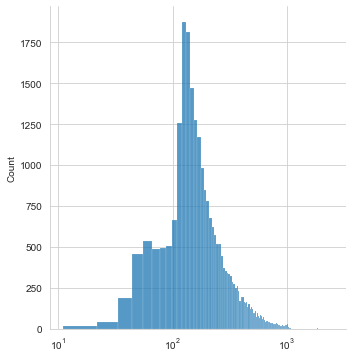

In [8]:
ax = sns.displot([len(review) for review in X_train])
ax.set(xscale='log');

## Prepare Data

In [9]:
maxlen = 100

In [10]:
X_train_padded = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test_padded = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [11]:
X_train_padded.shape, X_test_padded.shape

((25000, 100), (25000, 100))

In [12]:
K.clear_session()

In [13]:
embedding_size = 100

In [14]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim= embedding_size, 
              input_length=maxlen),
    GRU(units=32,  
        dropout=0.2, # comment out to use optimized GPU implementation
        recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,012,897
Trainable params: 2,012,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='RMSProp', 
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [16]:
rnn_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

In [17]:
early_stopping = EarlyStopping(monitor='val_AUC', 
                               mode='max',
                              patience=5,
                              restore_best_weights=True)

In [18]:
training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping, checkpointer],
                   verbose=1)

Epoch 1/100
782/782 [==============================] - 51s 61ms/step - loss: 0.5319 - accuracy: 0.7052 - AUC: 0.7810 - val_loss: 0.3403 - val_accuracy: 0.8508 - val_AUC: 0.9302

Epoch 00001: val_AUC improved from -inf to 0.93020, saving model to results/sentiment_imdb\lstm.h5
Epoch 2/100
782/782 [==============================] - 54s 69ms/step - loss: 0.2878 - accuracy: 0.8833 - AUC: 0.9491 - val_loss: 0.4505 - val_accuracy: 0.8199 - val_AUC: 0.9344

Epoch 00002: val_AUC improved from 0.93020 to 0.93443, saving model to results/sentiment_imdb\lstm.h5
Epoch 3/100
782/782 [==============================] - 52s 66ms/step - loss: 0.2343 - accuracy: 0.9066 - AUC: 0.9665 - val_loss: 0.3147 - val_accuracy: 0.8648 - val_AUC: 0.9407

Epoch 00003: val_AUC improved from 0.93443 to 0.94066, saving model to results/sentiment_imdb\lstm.h5
Epoch 4/100
782/782 [==============================] - 61s 78ms/step - loss: 0.1907 - accuracy: 0.9288 - AUC: 0.9768 - val_loss: 0.3497 - val_accuracy: 0.8606 - va

## Evaluate Results

In [19]:
history = pd.DataFrame(training.history)
history.index += 1

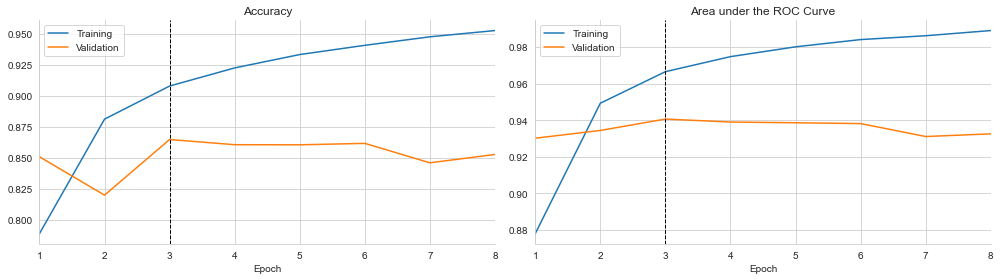

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
df1 = (history[['accuracy', 'val_accuracy']]
       .rename(columns={'accuracy': 'Training',
                        'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(history)))

axes[0].axvline(df1.Validation.idxmax(), ls='--', lw=1, c='k')

df2 = (history[['AUC', 'val_AUC']]
       .rename(columns={'AUC': 'Training',
                        'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(history)))

axes[1].axvline(df2.Validation.idxmax(), ls='--', lw=1, c='k')

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_imdb_cv', dpi=300)

In [21]:
y_score = rnn.predict(X_test_padded)
y_score.shape

(25000, 1)

In [22]:
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9406869056